# A CNN-VRNN Model for Polyphonic Music Generation

This notebook implements the CNN-VRNN model which can be used to generate novel samples of music based on a given piece of music.

- You can change the song being trained on by changing the file being pointed to by `input_song_file` in the first cell.
- Change the model file by changing `checkpoint_file` in the first cell.
- Tensorboard event files will be output to the tb/ directory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pretty_midi
import librosa
from datetime import datetime

%matplotlib inline
from IPython.display import Audio, display

checkpoint_file = './tfmodel/vae_sonic_onecnn_iter2000.tfmodel'
input_song_file = './audio_files/vgmusic/sonic_starlight_zone.mid'

In [2]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


## Load the song
Change `fs` to change the input beat resolution.

In [3]:
pm = pretty_midi.PrettyMIDI(input_song_file)
initial_tempo = pm.get_tempo_changes()[1][0]
fs = (initial_tempo / 60) * 8
piano_roll = pm.get_piano_roll(fs=fs)
piano_roll = (piano_roll.T > 0).astype(np.float32)

/opt/conda/lib/python2.7/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


## Set up constants
Change the constants in this cell to alter the parameters of the network (hidden layer sizes, number of epochs to run, midi frame size, etc.)

In [4]:
num_timesteps = int(fs)
note_range = 128
T = 16
num_batches = int(piano_roll.shape[0] // (fs * T))
height = num_timesteps
width = note_range
n_visible = note_range * num_timesteps
n_hidden = 512

num_epochs = 2000

z_dim = 256
X_dim = width * height
h_dim = n_hidden

initializer = tf.contrib.layers.xavier_initializer()

audio_sr = 44100

## Helper functions/models

In [5]:
def gru(inputs, size=512, initial_state=None, name="gru", reuse=False, dtype=tf.float32):
    with tf.variable_scope(name, reuse=reuse) as scope:
        cell = tf.contrib.rnn.GRUCell(size, reuse=reuse)
        input_shape = tf.shape(inputs)

        if initial_state is None:
            initial_state = cell.zero_state(batch_size=input_shape[0], dtype=dtype)

        outputs,state = tf.nn.dynamic_rnn(cell, inputs, 
                            initial_state=initial_state, dtype=dtype)
        return outputs, state
    
def conv_relu_pool(inputs, kernel_shape, pool_shape, name="conv2d", reuse=False, dtype=tf.float32):
    with tf.variable_scope(name) as scope:
        conv_kernel = tf.get_variable('conv2d', shape=kernel_shape, initializer=initializer, dtype=dtype)
        conv_bias = tf.get_variable('conv2d_b', shape=kernel_shape[3], dtype=dtype)
        
        conv = tf.nn.conv2d(inputs, conv_kernel, [1,1,1,1], "VALID")
        preact = tf.nn.bias_add(conv, conv_bias)
        relu = tf.nn.relu(preact)
        pool = tf.nn.max_pool(relu, pool_shape, pool_shape, "VALID")

        return pool

In [6]:
def midi_latent_feature(X, keep_prob=1.0, name='latent_feauture', reuse=False):
    with tf.variable_scope(name, reuse=reuse) as scope:
        conv1_out = conv_relu_pool(X, 
                                   kernel_shape=[2,2,1,32],
                                   pool_shape=[1, 2, 2, 1],
                                   name="conv_1")

        conv2_out = conv_relu_pool(conv1_out, 
                                   kernel_shape=[2, 2 , 32 , 32],
                                   pool_shape=[1, 2, 2, 1],
                                   name="conv_2")

        h = tf.contrib.layers.flatten(conv2_out)

        return tf.nn.dropout(h, keep_prob=keep_prob)

def Q(X, name_scope="Encoder", keep_prob=1.0):
    with tf.name_scope(name_scope):
        with tf.name_scope("Encoder_RNN"):
            #Expand dims for rnn to [1, T, k]
            rnn_in = tf.expand_dims(X, 0)
            rnn_outs, rnn_state = gru(rnn_in, size=z_dim, name="gru_enc")
            #Reshape
            rnn_state = tf.reshape(rnn_state[-1,:], [1, z_dim])
        
        with tf.name_scope("Calculate_mu_sigma"):
            Q_W2_mu = tf.get_variable('encoder_mean_weights', shape=[z_dim, z_dim], initializer=initializer)
            Q_b2_mu = tf.get_variable('encoder_mean_bias', shape=[z_dim], initializer=initializer)

            Q_W2_sigma = tf.get_variable('encoder_variance_weights', shape=[z_dim, z_dim], initializer=initializer)
            Q_b2_sigma = tf.get_variable('encoder_variance_bias', shape=[z_dim], initializer=initializer)
            #KL divergence with last GRU state
            z_mu = tf.matmul(rnn_state, Q_W2_mu) + Q_b2_mu
            z_logvar = tf.matmul(rnn_state, Q_W2_sigma) + Q_b2_sigma
        return z_mu, z_logvar

def sample_z(mu, log_var):
    with tf.name_scope("Random_samples"):
        eps = tf.random_normal(shape=tf.shape(mu))
        return mu + tf.exp(log_var / 2) * eps

In [7]:
def P(z, name_scope="Decoder", xt=None, keep_prob=1.0, reuse=False):
    with tf.name_scope(name_scope):
        with tf.name_scope("concatenate_noise_and_input"):
            #Expand dims for RNN
            if xt is not None:
                #Used to transform CNN representation
                P_W1 = tf.get_variable('P_W1', shape=[xt.get_shape().as_list()[1], z_dim], initializer=initializer)
                P_b1 = tf.get_variable('P_b1', shape=[z_dim], initializer=initializer)
                xt_in = tf.matmul(xt, P_W1) + P_b1
                z = tf.concat([z, xt_in], axis=0)
            z = tf.expand_dims(z, 0)

        with tf.name_scope("Decoder_RNN"):
            dec_outs, _ = gru(z, size=h_dim, name="gru_dec", reuse=reuse)
            dec_outs = tf.reshape(dec_outs, [-1, h_dim])

            drop = tf.nn.dropout(dec_outs, keep_prob=keep_prob)

            P_W2 = tf.get_variable('P_W2', shape=[h_dim, X_dim], initializer=initializer)
            P_b2 = tf.get_variable('P_b2', shape=[X_dim], initializer=initializer)

        logits = tf.matmul(drop, P_W2) + P_b2
        prob = tf.nn.sigmoid(logits)
        return prob, logits

## VAE-RNN model

In [8]:
z = tf.placeholder(tf.float32, shape=[None, z_dim], name="Generated_noise")
z_rnn_samples = tf.placeholder(tf.float32, shape=[None, height, width, 1], name="Generated_midi_input")

X = tf.placeholder(tf.float32, shape=[None, height, width, 1], name="Training_samples")

kl_annealing = tf.placeholder(tf.float32, name="KL_annealing_multiplier")

with tf.variable_scope('vae_rnn') as scope:
    
    latent_feature_enc = midi_latent_feature(X, name='CNN_Encoder')
    #latent_feature_dec = midi_latent_feature(X, name='cnn_dec')

    z_mu, z_logvar = Q(latent_feature_enc, name_scope="Encoder_train")
    z_sample = sample_z(z_mu, z_logvar)

    out_samples, logits = P(z_sample, name_scope="Decoder_train", xt=latent_feature_enc[:-1])

    # Sampling from random z
    scope.reuse_variables()
    latent_z_rnn = midi_latent_feature(z_rnn_samples, name='CNN_Encoder', reuse=True)
    X_samples, _ = P(z, name_scope="Decoder_test", xt=latent_z_rnn, reuse=True)

with tf.name_scope("Loss"):
    X_labels = tf.reshape(X, [-1, width*height])

    with tf.name_scope("cross_entropy"):
        recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X_labels), 1)
    with tf.name_scope("kl_divergence"):
        kl_loss = kl_annealing * 0.5 * tf.reduce_sum(tf.square(z_mu) + tf.square(z_logvar) - tf.log(tf.square(z_logvar)) - 1,1) 
    
    loss = tf.reduce_mean(recon_loss + kl_loss)

with tf.name_scope("Optimizer"):
    solver = tf.train.AdamOptimizer()
    grads = solver.compute_gradients(loss)
    grads = [(tf.clip_by_norm(g, clip_norm=10), v) for g, v in grads]
    train_op = solver.apply_gradients(grads)

In [9]:
with tf.name_scope("Logging"):
    recon_loss_ph = tf.placeholder(tf.float32)
    kl_loss_ph = tf.placeholder(tf.float32)
    loss_ph = tf.placeholder(tf.float32)
    audio_ph = tf.placeholder(tf.float32)

    tf.summary.scalar("Reconstruction_loss", recon_loss_ph)
    tf.summary.scalar("KL_loss", kl_loss_ph)
    tf.summary.scalar("Loss", loss_ph)
    tf.summary.audio("sample_output", audio_ph, audio_sr)
    log_op = tf.summary.merge_all()

writer = tf.summary.FileWriter('./tb/', graph=tf.get_default_graph())

In [10]:
def annealing_sched(epoch):
    return np.min([0.01*epoch, 1.])

In [11]:
saver = tf.train.Saver()

## Training

('Iter: ', 0)
('Loss: ', 651.94379)
('KL Loss:', array([ 75.47606659], dtype=float32))
('Recon Loss', array([ 1370.80407715,   895.28527832,   671.58984375,   576.95739746,
         525.79486084,   486.06729126,   496.04986572,   479.34893799,
         516.98773193,   453.44561768,   471.88897705,   455.34735107,
         486.49621582,   462.97042847,   438.1418457 ,   436.30749512], dtype=float32))


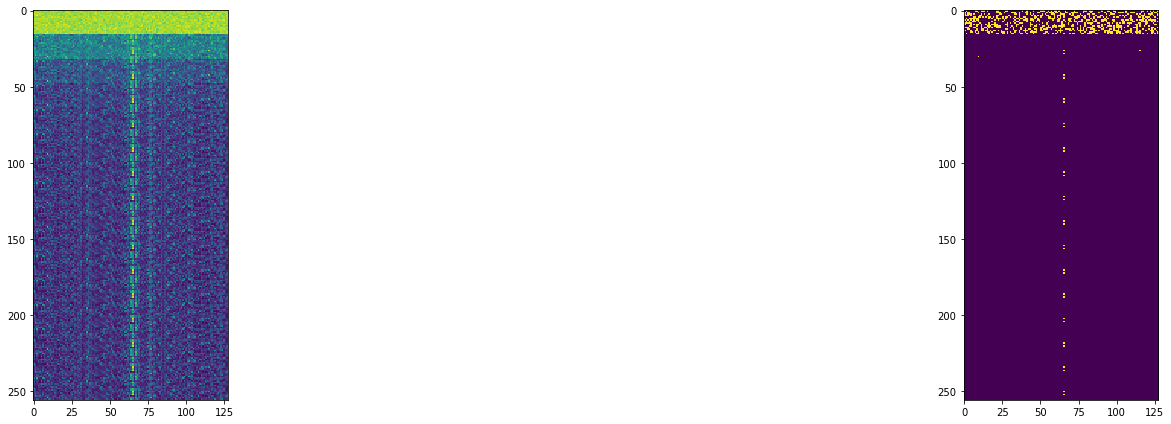

('Iter: ', 100)
('Loss: ', 35.235371)
('KL Loss:', array([ 2.38187981], dtype=float32))
('Recon Loss', array([ 266.00598145,   33.25417328,   16.43703651,   25.08202362,
         28.6168766 ,   27.98586082,   31.77584076,   24.37145996,
          7.33861208,    9.99725628,   10.60499668,   10.16048622,
         13.38022518,    9.3936224 ,    7.88196135,    3.36944985], dtype=float32))


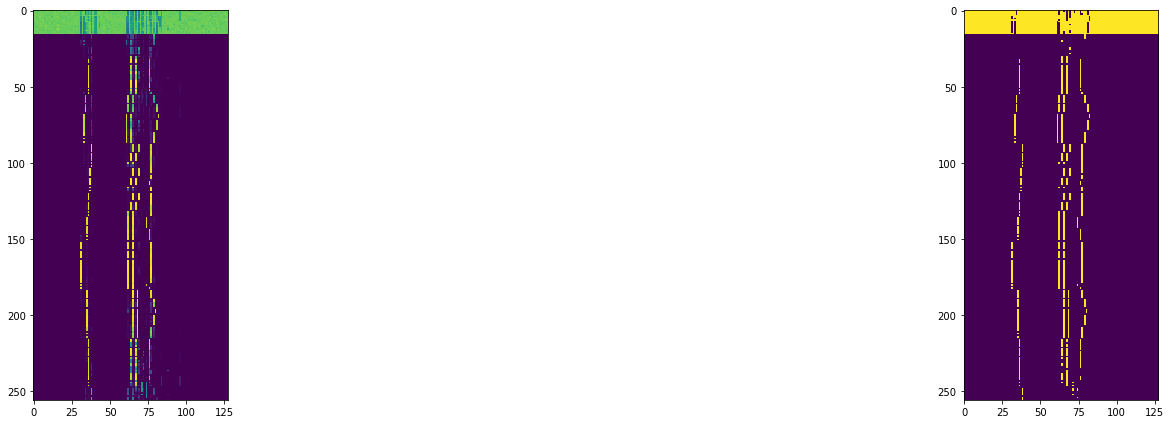

('Iter: ', 200)
('Loss: ', 16.407076)
('KL Loss:', array([ 1.61799431], dtype=float32))
('Recon Loss', array([ 197.6612854 ,    5.640975  ,    2.99140763,    3.63014531,
          4.41337299,    5.02573776,    4.57736921,    3.04773712,
          1.09215856,    0.99689019,    1.38529646,    1.28706515,
          1.20399356,    1.40882635,    1.68416226,    0.57887185], dtype=float32))


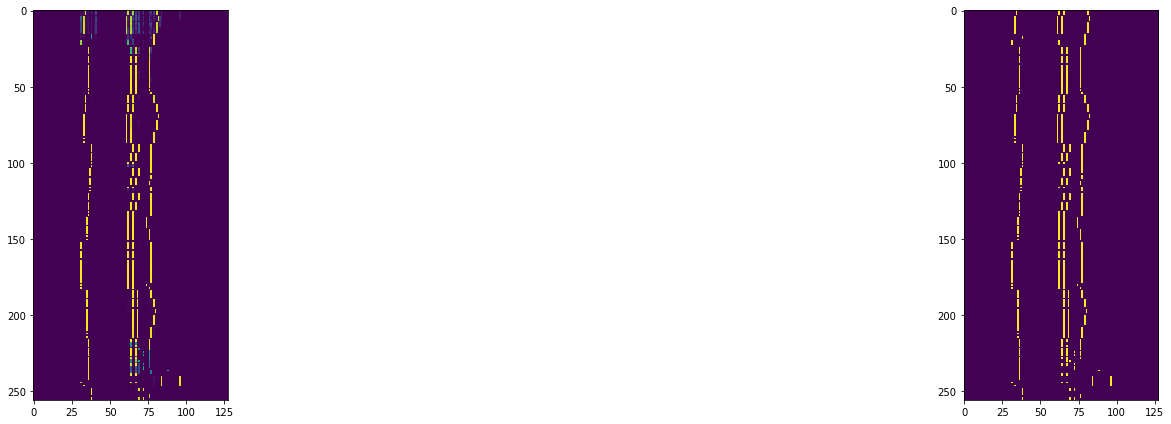

('Iter: ', 300)
('Loss: ', 7.3092403)
('KL Loss:', array([ 4.47766018], dtype=float32))
('Recon Loss', array([ 29.6026001 ,   2.71716785,   1.01668859,   1.15391004,
         1.56203091,   2.31173372,   1.69447815,   1.36552143,
         0.55569422,   0.39435971,   0.5524649 ,   0.47903287,
         0.43968803,   0.64032978,   0.5750072 ,   0.24456762], dtype=float32))


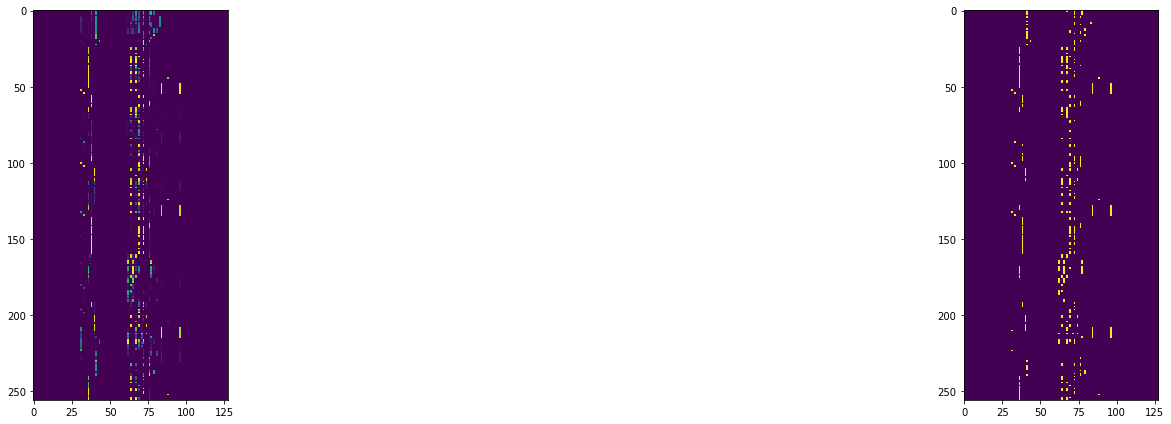

('Iter: ', 400)
('Loss: ', 3.3855715)
('KL Loss:', array([ 1.56432438], dtype=float32))
('Recon Loss', array([ 22.00497627,   1.09230316,   0.42206669,   0.57819062,
         0.81191045,   0.89782339,   0.76010144,   0.64989042,
         0.37718466,   0.21306928,   0.26047945,   0.25113609,
         0.17047128,   0.28711995,   0.24608068,   0.11715076], dtype=float32))


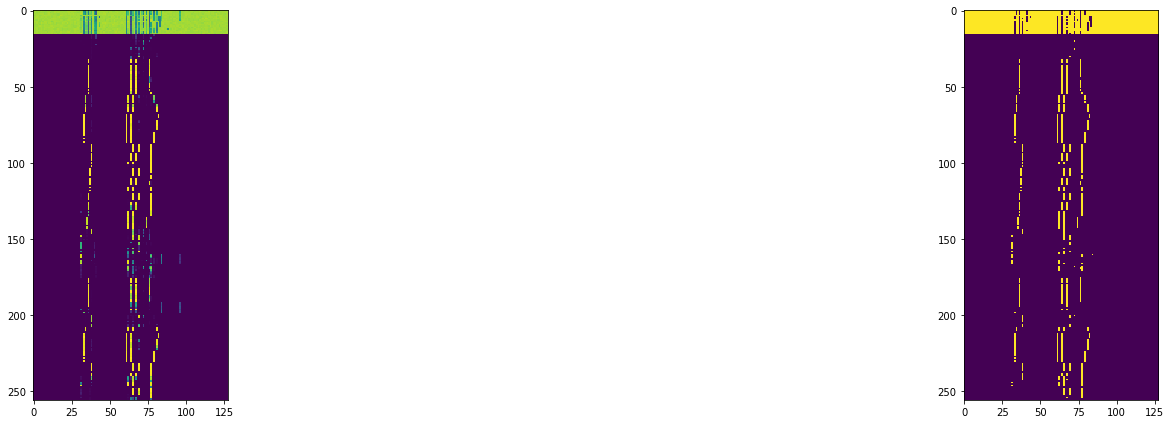

('Iter: ', 500)
('Loss: ', 3.4934177)
('KL Loss:', array([ 2.14447403], dtype=float32))
('Recon Loss', array([ 17.09228134,   0.6683687 ,   0.23681253,   0.36597773,
         0.42122781,   0.53221393,   0.46275795,   0.49511138,
         0.28151143,   0.11625521,   0.16004464,   0.14744075,
         0.20347537,   0.18511541,   0.14023018,   0.0742734 ], dtype=float32))


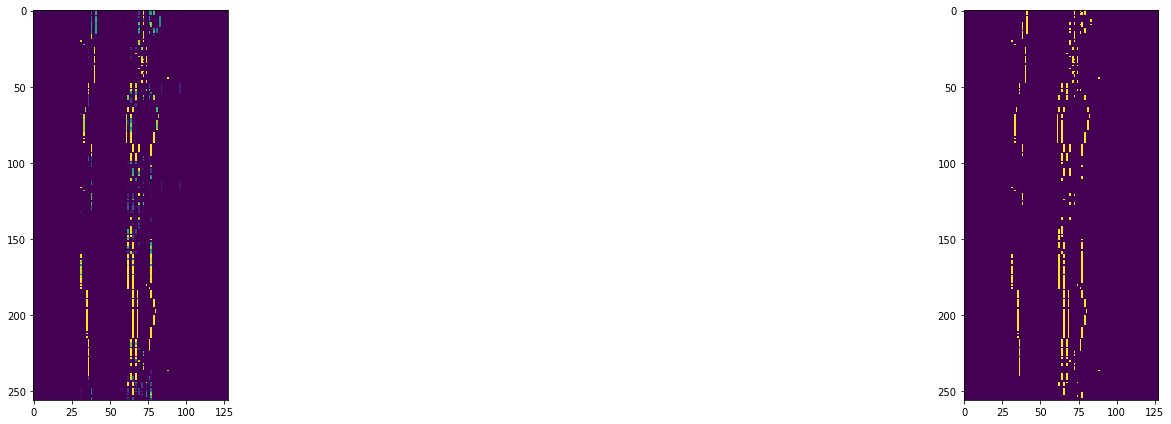

('Iter: ', 600)
('Loss: ', 3.8137717)
('KL Loss:', array([ 2.87121248], dtype=float32))
('Recon Loss', array([ 12.59956169,   0.29720119,   0.13822398,   0.2606011 ,
         0.21389546,   0.30041927,   0.26563162,   0.25965485,
         0.16060114,   0.0895787 ,   0.09012958,   0.08992154,
         0.08454627,   0.09810572,   0.08604058,   0.04683659], dtype=float32))


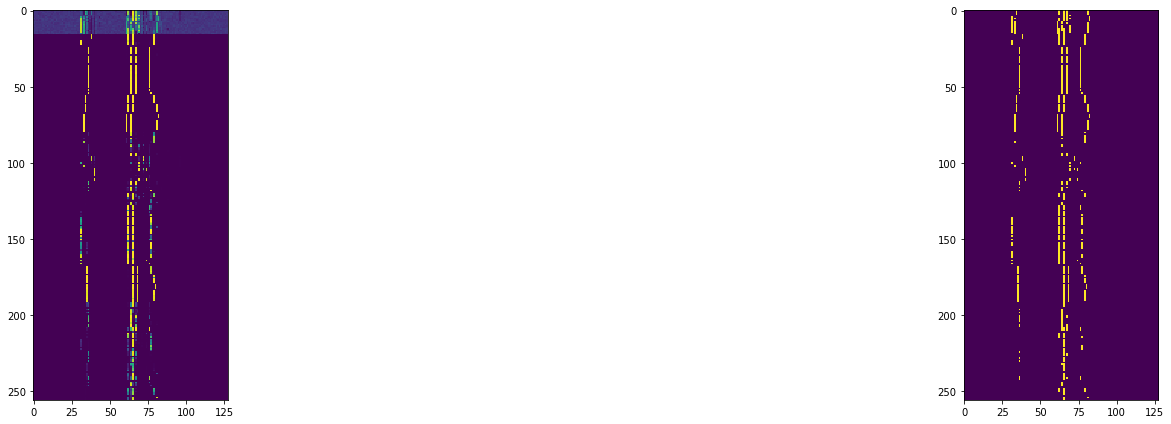

('Iter: ', 700)
('Loss: ', 2.3144946)
('KL Loss:', array([ 1.46590614], dtype=float32))
('Recon Loss', array([ 11.72517872,   0.30937737,   0.08151451,   0.18827713,
         0.1314473 ,   0.23370843,   0.20109473,   0.19220102,
         0.12459771,   0.06494205,   0.07185609,   0.05733372,
         0.03931996,   0.0661773 ,   0.05457816,   0.03581017], dtype=float32))


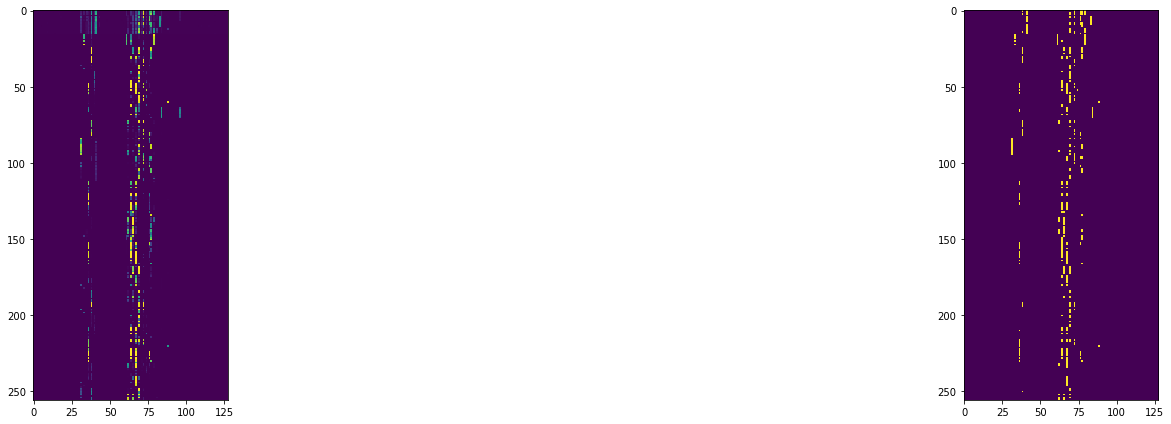

('Iter: ', 800)
('Loss: ', 2.417742)
('KL Loss:', array([ 0.96927589], dtype=float32))
('Recon Loss', array([  2.18835621e+01,   1.55637741e-01,   6.20945580e-02,
         1.38715371e-01,   1.18774056e-01,   1.58138320e-01,
         1.52992293e-01,   1.32373154e-01,   9.67821628e-02,
         4.33431827e-02,   3.72720510e-02,   4.78580110e-02,
         1.29712308e-02,   6.21640161e-02,   4.91926931e-02,
         2.35862583e-02], dtype=float32))


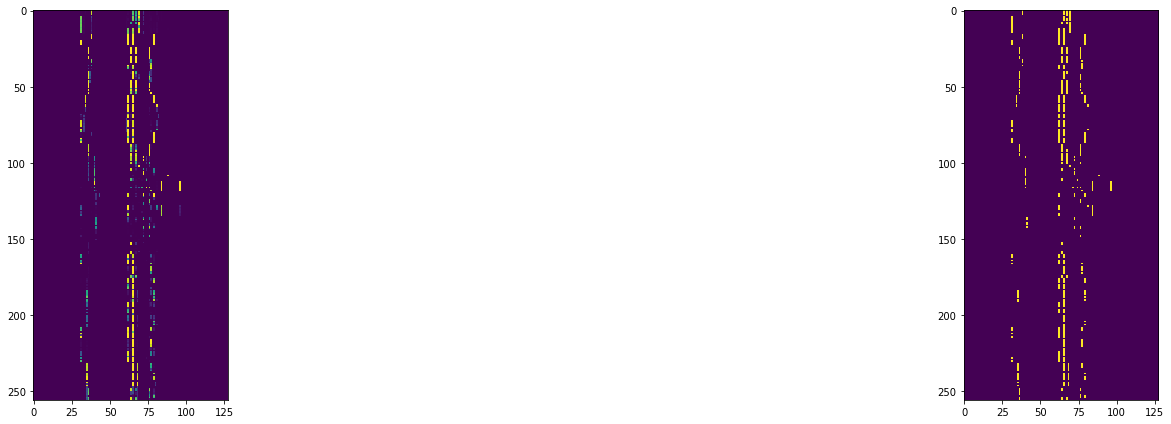

('Iter: ', 900)
('Loss: ', 3.1763263)
('KL Loss:', array([ 1.20033026], dtype=float32))
('Recon Loss', array([  3.05668869e+01,   1.56328574e-01,   4.82579432e-02,
         1.21831521e-01,   1.16736032e-01,   1.36623755e-01,
         9.89025980e-02,   1.11918621e-01,   6.31956458e-02,
         3.78778018e-02,   2.74613034e-02,   3.45259346e-02,
         8.95095803e-03,   3.21178809e-02,   3.51521038e-02,
         1.91651080e-02], dtype=float32))


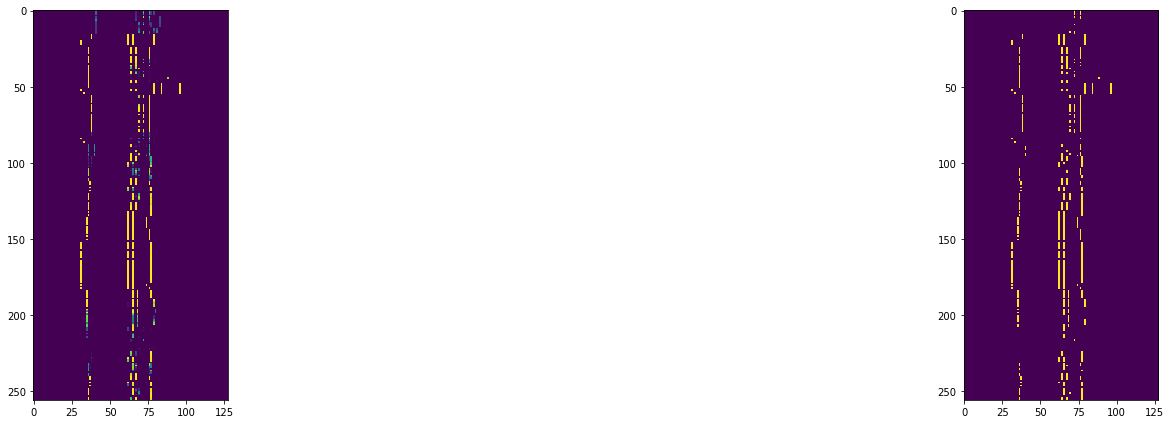

('Iter: ', 1000)
('Loss: ', 2.4257944)
('KL Loss:', array([ 2.16819334], dtype=float32))
('Recon Loss', array([ 3.44560719,  0.08611433,  0.02685078,  0.06189545,  0.05975815,
        0.08646743,  0.06783018,  0.08155941,  0.05877996,  0.02926224,
        0.01855806,  0.02381796,  0.01311176,  0.022423  ,  0.02413249,
        0.01544616], dtype=float32))


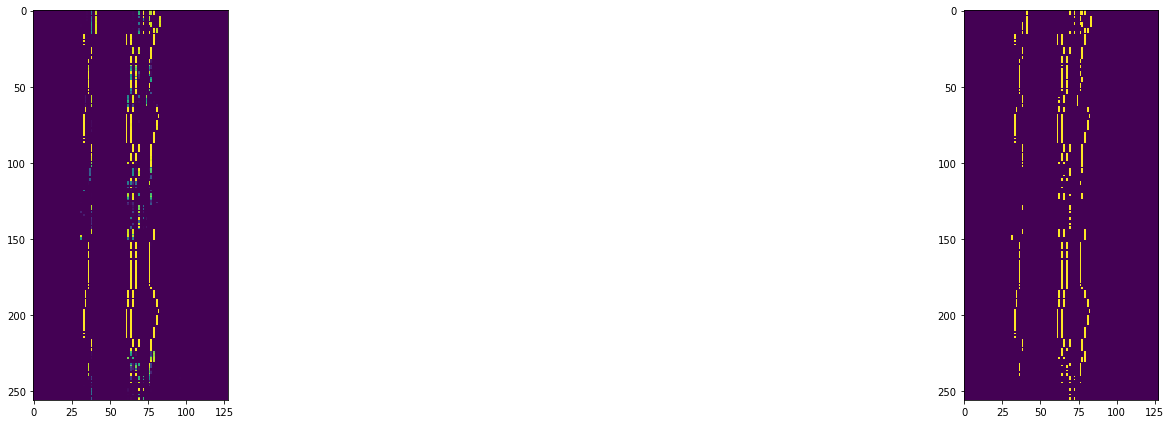

('Iter: ', 1100)
('Loss: ', 24.710232)
('KL Loss:', array([ 1.52574682], dtype=float32))
('Recon Loss', array([  3.70045654e+02,   1.83733121e-01,   5.30831106e-02,
         8.72828513e-02,   9.45408493e-02,   7.43230283e-02,
         8.62246305e-02,   7.46481046e-02,   6.75106719e-02,
         3.38505022e-02,   2.18244419e-02,   2.92570610e-02,
         5.62946685e-03,   3.47943418e-02,   4.49487381e-02,
         1.44684510e-02], dtype=float32))


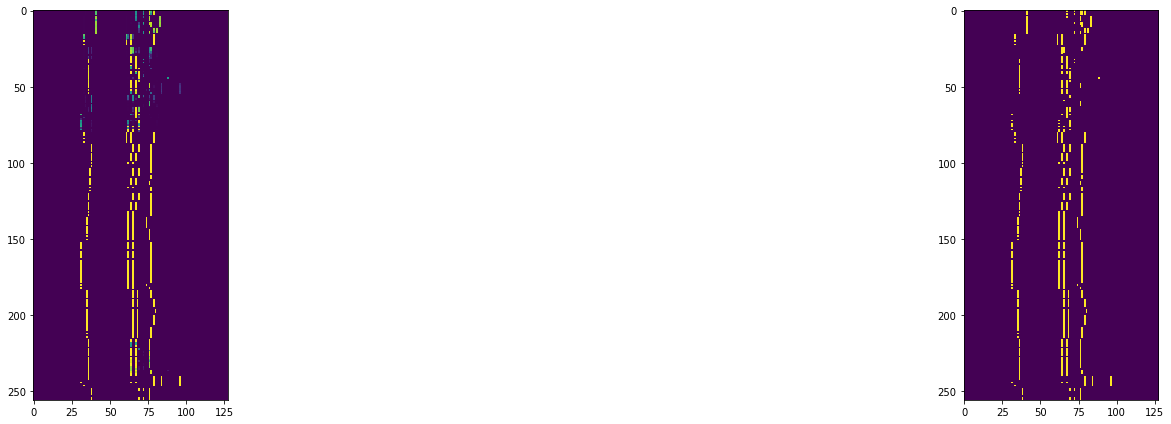

('Iter: ', 1200)
('Loss: ', 15.890867)
('KL Loss:', array([ 1.41249967], dtype=float32))
('Recon Loss', array([  2.31141022e+02,   6.62366524e-02,   2.52455957e-02,
         4.18768302e-02,   4.73203063e-02,   5.39183803e-02,
         6.16663098e-02,   5.18618450e-02,   5.09050563e-02,
         2.75721885e-02,   1.42346406e-02,   1.78538691e-02,
         4.17093467e-03,   1.94047354e-02,   1.93892773e-02,
         1.12070143e-02], dtype=float32))


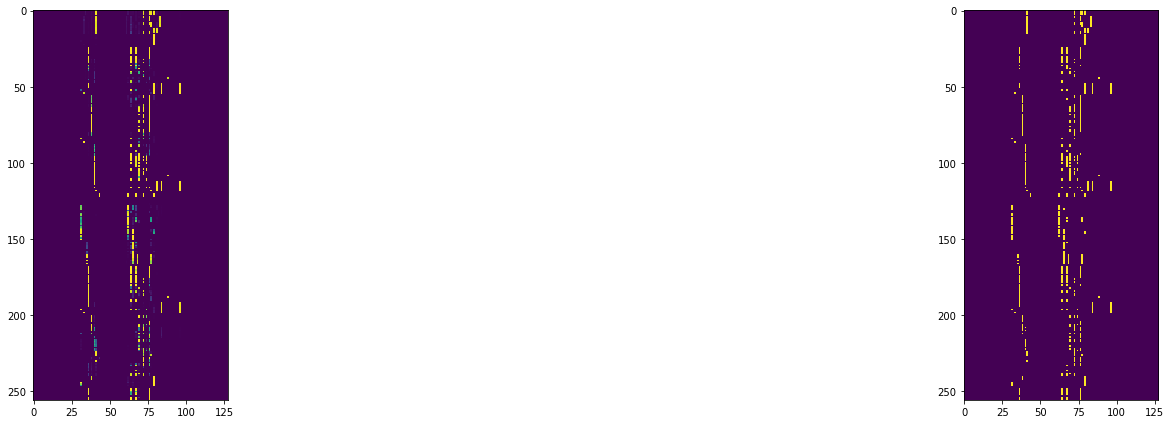

('Iter: ', 1300)
('Loss: ', 2.1304095)
('KL Loss:', array([ 1.9366734], dtype=float32))
('Recon Loss', array([ 2.69688344,  0.06337301,  0.01621562,  0.03694002,  0.02756192,
        0.04519209,  0.03856275,  0.04536074,  0.03888377,  0.01563553,
        0.01225508,  0.01611685,  0.00625503,  0.01788627,  0.01408726,
        0.00856885], dtype=float32))


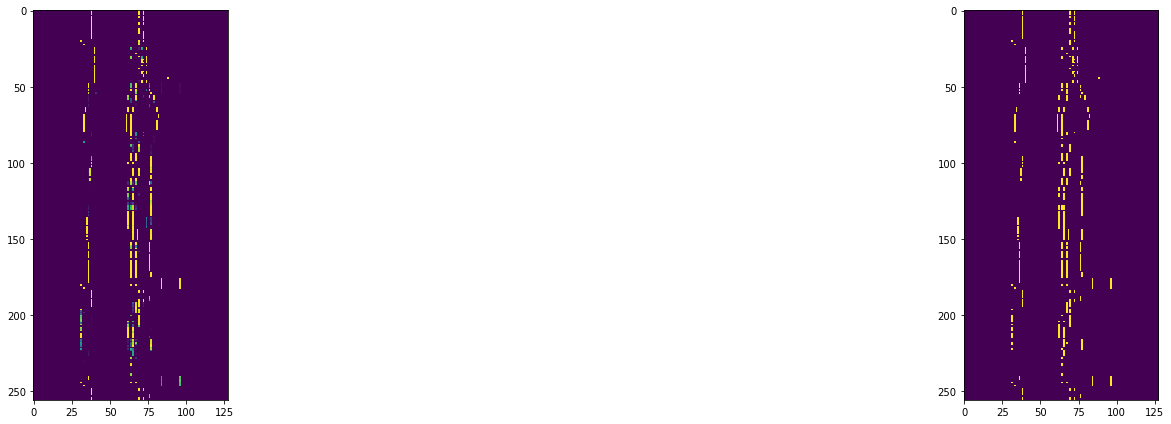

('Iter: ', 1400)
('Loss: ', 1.335165)
('KL Loss:', array([ 1.27036691], dtype=float32))
('Recon Loss', array([ 0.70573622,  0.03410938,  0.01383026,  0.03108079,  0.02939882,
        0.03736938,  0.03572131,  0.03983018,  0.03511746,  0.01591498,
        0.0096802 ,  0.0111177 ,  0.00402746,  0.01346169,  0.01170927,
        0.00866528], dtype=float32))


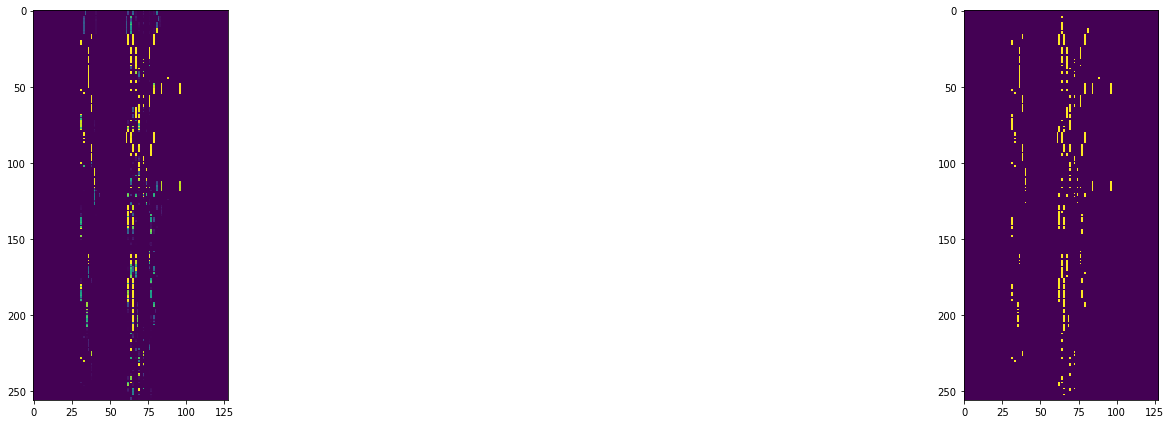

('Iter: ', 1500)
('Loss: ', 1.371881)
('KL Loss:', array([ 1.30550027], dtype=float32))
('Recon Loss', array([ 0.74319726,  0.04613874,  0.01407287,  0.02749468,  0.02548694,
        0.03170173,  0.02830809,  0.0350797 ,  0.03407775,  0.013678  ,
        0.01088868,  0.0120673 ,  0.00510617,  0.01250374,  0.01452877,
        0.00776079], dtype=float32))


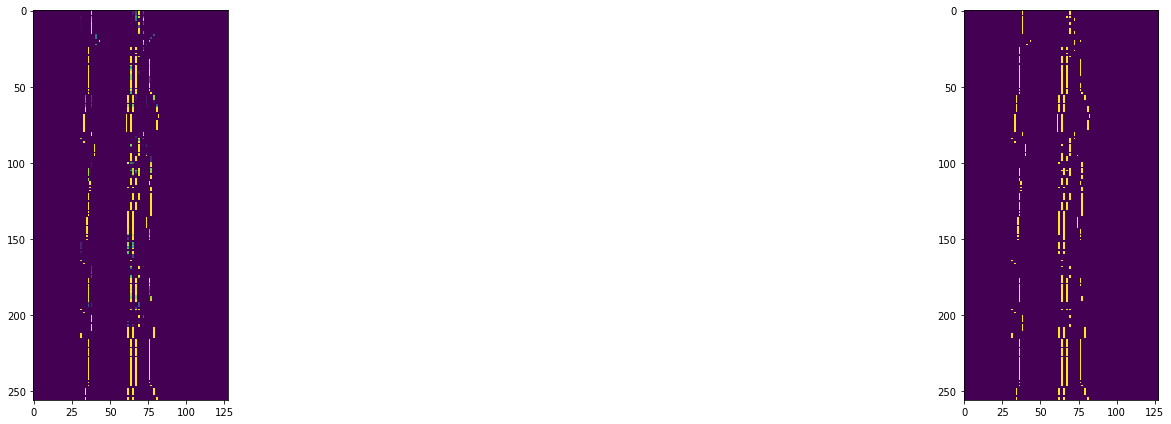

('Iter: ', 1600)
('Loss: ', 2.2368121)
('KL Loss:', array([ 1.93793869], dtype=float32))
('Recon Loss', array([ 4.48680115,  0.03506359,  0.01177255,  0.02252063,  0.02853894,
        0.03523749,  0.02501157,  0.03380989,  0.03421166,  0.01192224,
        0.007783  ,  0.01120236,  0.00711561,  0.01186331,  0.01199506,
        0.00712476], dtype=float32))


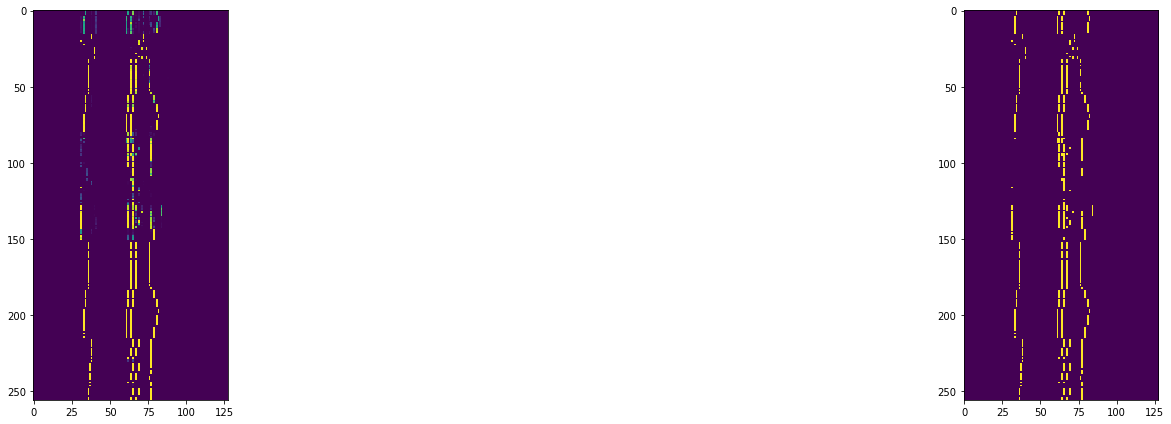

('Iter: ', 1700)
('Loss: ', 1.0533991)
('KL Loss:', array([ 0.98706418], dtype=float32))
('Recon Loss', array([ 0.7848382 ,  0.03354592,  0.01261361,  0.02155776,  0.02503776,
        0.02824192,  0.02599547,  0.03407118,  0.03457054,  0.01218043,
        0.00963814,  0.00901837,  0.00399018,  0.01092093,  0.00868693,
        0.00645039], dtype=float32))


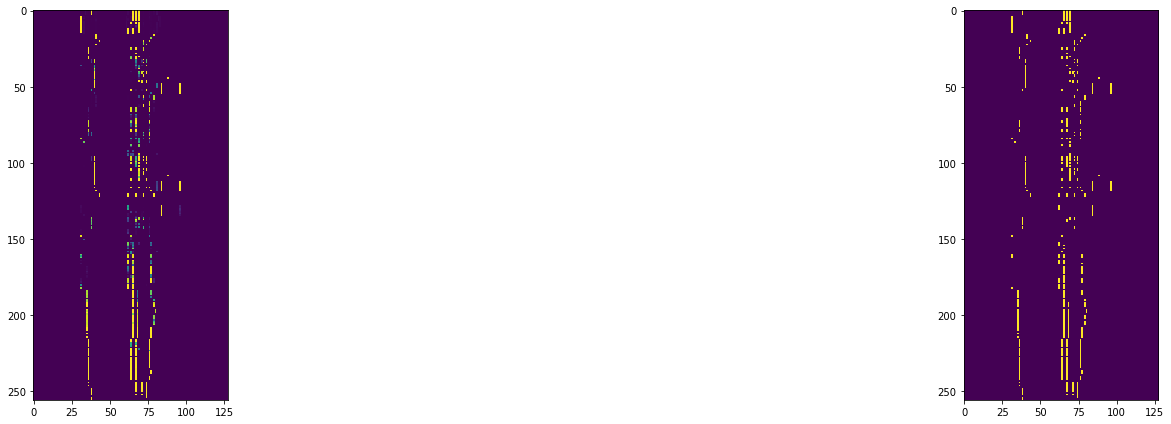

('Iter: ', 1800)
('Loss: ', 15.362257)
('KL Loss:', array([ 1.00295186], dtype=float32))
('Recon Loss', array([  2.29429382e+02,   9.07635689e-02,   1.40973292e-02,
         2.69347001e-02,   2.55391803e-02,   3.19188088e-02,
         1.95269100e-02,   2.82184985e-02,   3.01782656e-02,
         1.20905722e-02,   6.62844395e-03,   7.88034964e-03,
         3.61624872e-03,   7.59413466e-03,   9.45559796e-03,
         5.07265190e-03], dtype=float32))


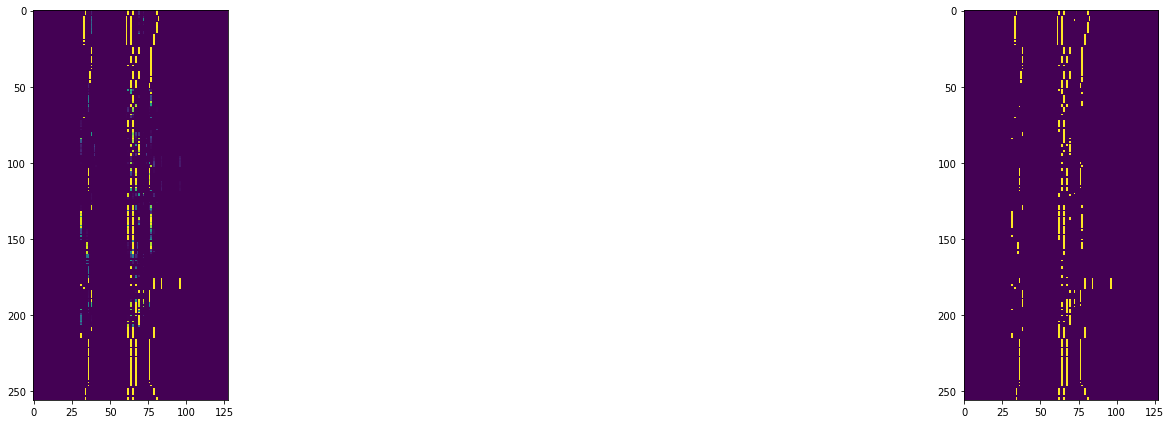

('Iter: ', 1900)
('Loss: ', 3.7593246)
('KL Loss:', array([ 2.12876558], dtype=float32))
('Recon Loss', array([  2.58400459e+01,   2.89273094e-02,   1.80666689e-02,
         1.99703202e-02,   1.99416429e-02,   2.02325527e-02,
         2.61841733e-02,   2.80181337e-02,   3.32035981e-02,
         1.11288568e-02,   6.23906497e-03,   1.01071810e-02,
         3.76438675e-03,   8.69928952e-03,   9.00317449e-03,
         5.41484961e-03], dtype=float32))


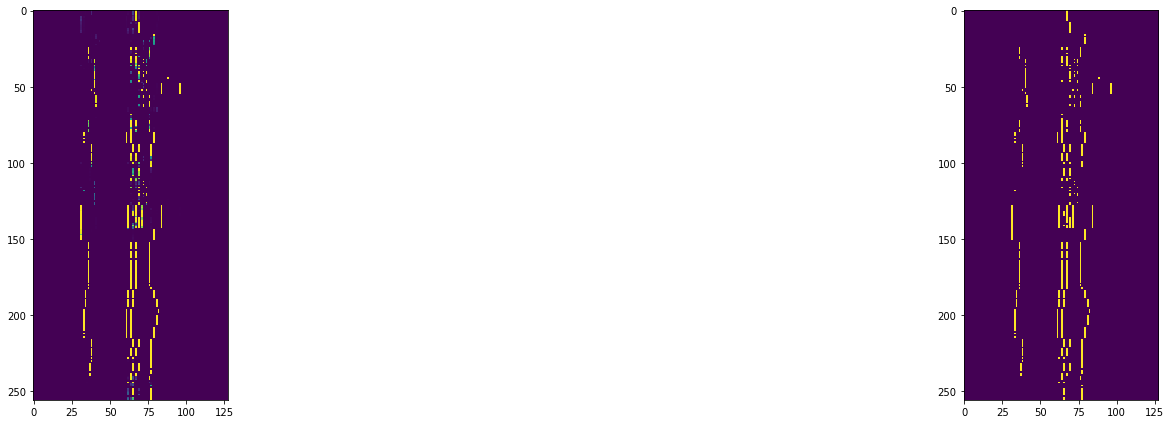

('Iter: ', 2000)
('Loss: ', 5.7732606)
('KL Loss:', array([ 1.33908606], dtype=float32))
('Recon Loss', array([  7.03790131e+01,   8.79218131e-02,   3.98985632e-02,
         5.70036210e-02,   5.10607474e-02,   6.10184222e-02,
         5.44868857e-02,   6.09992743e-02,   5.31868935e-02,
         2.28827540e-02,   1.23119792e-02,   1.16963265e-02,
         6.39491156e-03,   1.70693807e-02,   1.80002749e-02,
         1.38443159e-02], dtype=float32))


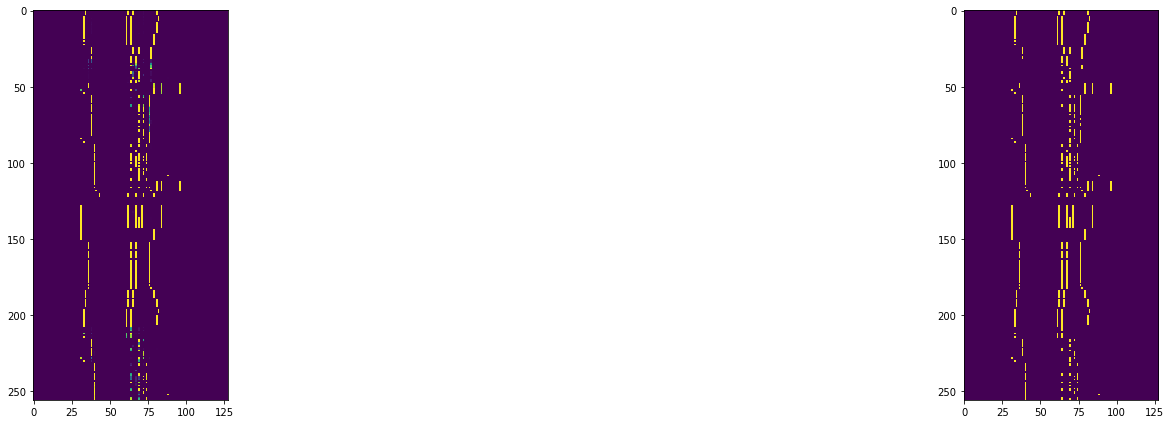

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    while i <= num_epochs:
        #s = song[20:20+num_timesteps,:].reshape(1,num_timesteps*2*note_range)
        for b in range(num_batches):
            s = piano_roll[b*T*num_timesteps:(b+1)*T*num_timesteps, :note_range].reshape(T, height, width, 1)
            kla = annealing_sched(i)
            #X_mb = song[(ind*num_timesteps):num_timesteps*(ind + 1), :].reshape(1, height, width, 1)
            _,loss_out, kl, recon = sess.run([train_op, loss, kl_loss, recon_loss], feed_dict={X: s, kl_annealing: 1.0})

        if i % 100 == 0:
            print('Iter: ', i)
            print('Loss: ', loss_out)
            print('KL Loss:', kl)
            print('Recon Loss', recon)

            #Random samples
            z_in = np.random.randn(1, z_dim)
            z_rnn_out = np.zeros((1,height,width,1))
            first = True
            for j in range(T):
                samples = sess.run(X_samples, feed_dict={z: np.random.randn(1, z_dim), z_rnn_samples: z_rnn_out})
                frames = j + 1
                if first:
                    frames = 2
                z_rnn_out = samples.reshape((frames, height, width, 1))
                if first:
                    z_rnn_out = np.expand_dims(z_rnn_out[-1,:,:,:], axis=0)
                    first = False
            samples = samples.reshape((num_timesteps*T, note_range))
            thresh_S = samples >= 0.5
            plt.figure(figsize=(36,6))
            plt.subplot(1,2,1)
            plt.imshow(samples)
            plt.subplot(1,2,2)
            plt.imshow(thresh_S)
            plt.tight_layout()
            plt.pause(0.1)
            
            pm_out = piano_roll_to_pretty_midi(thresh_S.T * 127, fs=fs)
            midi_out = './tb/audio/test002_{0}.mid'.format(datetime.now().strftime("%Y.%m.%d.%H:%M:%S"))
            wav_out = './tb/audio/test002_{0}.wav'.format(datetime.now().strftime("%Y.%m.%d.%H:%M:%S"))
            audio = pm_out.synthesize() 
            audio = audio.reshape((1, len(audio)))
            #Write out logs
            summary = sess.run(log_op, feed_dict={recon_loss_ph: np.mean(recon), kl_loss_ph: np.mean(kl),
                                                 loss_ph: loss_out, audio_ph: audio})
            writer.add_summary(summary, i)
        
        i += 1
        saver.save(sess, checkpoint_file)

## Testing

INFO:tensorflow:Restoring parameters from ./tfmodel/vae_sonic_onecnn_iter2000.tfmodel


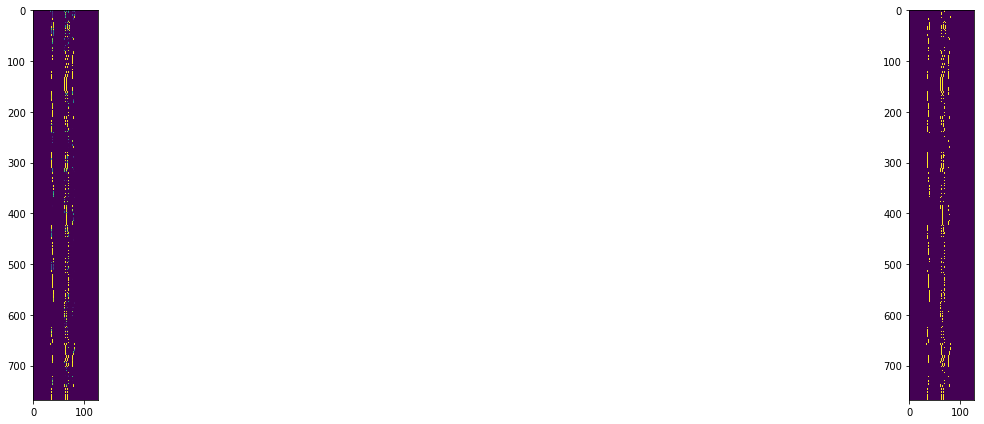

In [14]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_file)
    #Generate T frames
   
    #Random samples
    z_in = np.random.randn(1, z_dim)
    z_rnn_out = np.zeros((1,height,width,1))
    first = True
    for j in range(T*3):
        sams = sess.run(X_samples, feed_dict={z: np.random.randn(1, z_dim), z_rnn_samples: z_rnn_out})
        frames = j + 1
        if first:
            frames = 2
        z_rnn_out = sams.reshape((frames, height, width, 1))
        if first:
            z_rnn_out = np.expand_dims(z_rnn_out[-1,:,:,:], axis=0)
            first = False
    sams = sams.reshape((num_timesteps*T*3, note_range))
    thresh_S = (sams >= 0.5).astype(np.float32) * 127
    plt.figure(figsize=(36,6))
    plt.subplot(1,2,1)
    plt.imshow(sams)
    plt.subplot(1,2,2)
    plt.imshow(thresh_S)
    plt.tight_layout()
    plt.pause(0.1)
    pm = piano_roll_to_pretty_midi(thresh_S.T, fs)
    pm.write('./output/test.mid')